# Quick intro

This is a jupyter notebook for testing / coding. So far, each code block is a separate test; unlike an ordinary notebook, they are not meant to run sequentially.

First, test to see jupyter is running correctly at all:


In [1]:
import os
import sys

print("hi!!! you")

hi!!! you


Do grads apply through hessians?

In [21]:
import myhessian
import torch
ts = torch.tensor
t = ts([i+.5 for i in range(5)], requires_grad=True)
l = torch.sum(t**3)
[lg] = torch.autograd.grad(l,t,create_graph=True,retain_graph=True)
[lgg] = torch.autograd.grad(lg[1],t,create_graph=True,retain_graph=True)
lgg2 = lgg.contiguous().view(-1)
print(lgg2.size())
lgg3 = torch.zeros(6,6)#,requires_grad=True)
lgg3[1,1:].add_(lgg2.type_as(lgg3))
print(lg)
h = myhessian.hessian(l,t)
l2 = torch.sum(lgg3)
l2.backward()
print(t.grad)
print(lgg3.requires_grad)

torch.Size([5])
tensor([ 0.7500,  6.7500, 18.7500, 36.7500, 60.7500], grad_fn=<MulBackward0>)
tensor([0., 6., 0., 0., 0.])
True


Can you add grads post-hoc?

In [25]:
from torch import *

t1 = torch.tensor(1., requires_grad=True)
t1b = t1.detach().requires_grad_()
t2 = 2 * t1b
t3 = t2 * t1
print(t2.grad_fn)
temp = t2.grad_fn
#t2.grad_fn = None
t3.backward(retain_graph=True)
print(t1.grad)
t3.backward(retain_graph=True)
print(t1.grad)
#t2.requires_grad = False
t3.backward(retain_graph=True)
print(t1.grad)
#t2.requires_grad = True
t3.backward(retain_graph=True)
print(t1.grad)
t1.grad = t1.grad + t1b.grad
print(t1.grad)
t3.backward(retain_graph=True)
print(t1.grad)
t3.extra_attr = 3
print(t3.extra_attr)


tensor(2.)
tensor(4.)
tensor(6.)
tensor(8.)
tensor(16.)
tensor(18.)
3


Do I have the Euler constant right?

In [17]:
import pyro
from pyro import distributions as dist
import torch

EULER_CONSTANT = 0.5772156649015328606065120900824024310421
gd = dist.Gumbel(torch.tensor(-EULER_CONSTANT),torch.tensor(1.))
print(gd.sample())
torch.mean(gd.sample([1000000]))


tensor(-1.3647)


tensor(0.0003)

Does the "linearize then delinearize" trick work?

In [1]:
import torch
import myhessian

t1 = torch.ones(2,2,requires_grad = True)
ys = []
ws = []
y2 = []
for i in range(5):
    ys.append(torch.ones(1,requires_grad = True) * i)
    ws.append(ys[i] * (i+1))
    y2.append(ws[i] / (i+1))
    
y = torch.cat(y2,0)
output = torch.sum(t1**2) + torch.sum(y**2)


hess,grad = myhessian.hessian(output,[t1]+ws,return_grad=True,allow_unused=True)

print(hess,grad) 
#good graph

t1 = torch.ones(2,2,requires_grad = True)
ys = []
ws = []
y2 = []
for i in range(5):
    ys.append(torch.ones(1,requires_grad = True) * i)
    ws.append(ys[i] * (i+1))
    y2.append(ws[i] / (i+1))
    
y = torch.cat(ys,0)
output = torch.sum(t1**2) + torch.sum(y**2)

hess,grad = myhessian.hessian(output,[t1]+ws,return_grad=True,allow_unused=True)

print(hess,grad) #bad graph too sparse

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2222, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0800]],
       grad_fn=<CopySlices>) tensor([2.0000, 2.0000, 2.0000, 2.0000, 0.0000, 1.0000, 1.3333, 1.5000, 1.6000],
       grad_fn=<CatBackward>)
tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 

What do the values mean in format_shapes?

In [11]:
import os
import torch
import pyro
from torch.distributions import constraints
from pyro.distributions import Bernoulli, Categorical, MultivariateNormal, Multinomial, Normal
from pyro.distributions.util import broadcast_shape
from pyro.infer import Trace_ELBO, TraceEnum_ELBO, config_enumerate
import pyro.poutine as poutine
from pyro.optim import Adam

# We'll ue this helper to check our models are correct.
def test_model(model, guide, loss):
    pyro.clear_param_store()
    loss.loss(model, guide)
    
def model1():
    a = pyro.sample("a", Normal(0, 1))
    b = pyro.sample("b", Normal(torch.zeros(2), 1).to_event(1))
    with pyro.plate("c_plate", 2):
        c = pyro.sample("c", Normal(torch.zeros(2), 1))
    with pyro.plate("d_plate", 3):
        d = pyro.sample("d", Multinomial(5,torch.ones(3,4,5)).to_event(1))
    assert a.shape == ()       # batch_shape == ()     event_shape == ()
    assert b.shape == (2,)     # batch_shape == ()     event_shape == (2,)
    assert c.shape == (2,)     # batch_shape == (2,)   event_sahpe == ()
    assert d.shape == (3,4,5)  # batch_shape == (3,)   event_shape == (4,5)

    x_axis = pyro.plate("x_axis", 3, dim=-2)
    y_axis = pyro.plate("y_axis", 2, dim=-3)
    with x_axis:
        x = pyro.sample("x", Normal(0, 1))
    with y_axis:
        y = pyro.sample("y", Normal(0, 1))
    with x_axis, y_axis:
        xy = pyro.sample("xy", Normal(0, 1))
        z = pyro.sample("z", Normal(0, 1).expand([5]).to_event(1))
    assert x.shape == (3, 1)        # batch_shape == (3,1)     event_shape == ()
    assert y.shape == (2, 1, 1)     # batch_shape == (2,1,1)   event_shape == ()
    assert xy.shape == (2, 3, 1)    # batch_shape == (2,3,1)   event_shape == ()
    assert z.shape == (2, 3, 1, 5)  # batch_shape == (2,3,1)   event_shape == (5,)

test_model(model1, model1, Trace_ELBO())

trace = poutine.trace(model1).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

Trace Shapes:            
 Param Sites:            
Sample Sites:            
       a dist       |    
        value       |    
     log_prob       |    
       b dist       | 2  
        value       | 2  
     log_prob       |    
 c_plate dist       |    
        value     2 |    
     log_prob       |    
       c dist     2 |    
        value     2 |    
     log_prob     2 |    
 d_plate dist       |    
        value     3 |    
     log_prob       |    
       d dist     3 | 4 5
        value     3 | 4 5
     log_prob     3 |    
  x_axis dist       |    
        value     3 |    
     log_prob       |    
  y_axis dist       |    
        value     2 |    
     log_prob       |    
       x dist   3 1 |    
        value   3 1 |    
     log_prob   3 1 |    
       y dist 2 1 1 |    
        value 2 1 1 |    
     log_prob 2 1 1 |    
      xy dist 2 3 1 |    
        value 2 3 1 |    
     log_prob 2 3 1 |    
       z dist 2 3 1 | 5  
        value 2 3 1 | 5  
     log_pro

Does my gumbel MLE function work?

In [ ]:
from importlib import reload
import demo #import *
reload(demo)
from demo import *
import cProfile as profile

print("hi")

print(lambertw(ts([0.])),lambertw(ts([1.])),lambertw(ts([50.])))
print("hi")

testMLE()

draw some ellipses:


Ellipse(xy=(0, 0), width=2.0, height=2.0, angle=0)
hi


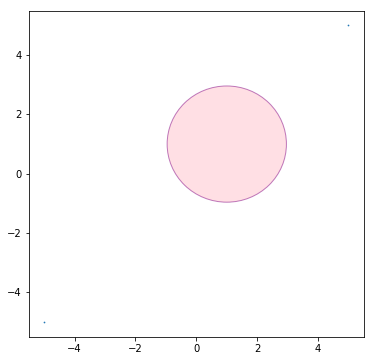

In [7]:
from draw_ellipses import *
import torch


fig, ax_nstd = plt.subplots(figsize=(6, 6))
lims = [-5,5]
ax_nstd.scatter(lims, lims, s=0.5)

confidence_ellipse(torch.ones(2),torch.eye(2),ax_nstd,alpha=0.5, facecolor='pink', edgecolor='purple', zorder=0)
print("hi")
plt.show()